# Loading Packages and Utility Functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
from typing import List, Tuple, Union
import time

In [4]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output"
file_list = [fname for fname in os.listdir(root_output_path) if fname.endswith(".json")]
file_list

['data_princeton-nlp-Sheared-LLaMA-1-3B_n500_synthid.json',
 'data_facebook-opt-1-3b_n500_pf.json',
 'data_facebook-opt-125m_n500_inverse.json',
 'data_google-gemma-3-270m_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_unwatermarked.json',
 'data_google-gemma-3-270m_n500_inverse.json',
 'data_facebook-opt-1-3b_n500_redgreen.json',
 'data_google-gemma-3-270m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_synthid.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_pf.json',
 'data_facebook-opt-125m_n500_unwatermarked.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_inverse.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_unwatermarked.json',
 'data_facebook-opt-125m_n500_gumbel.json',
 'data_facebook-opt-125m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_gumbel.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_inverse.json',
 'data_facebook-opt-125m_n500_pf.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_redgreen.json',
 

In [5]:
# IOU is the typical metric that is tracked in these scenarios
def get_iou(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]]):
    coordsA = set([x for start, end in intervalsA for x in range(start, end)])
    coordsB = set([x for start, end in intervalsB for x in range(start, end)])
    num = len(coordsA.intersection(coordsB))
    denom = len(coordsA.union(coordsB))
    return (num / denom)

# metric to find the symmetric differences
def get_symmetric_difference(intA, intB):
  sA, eA = intA
  sB, eB = intB
  return abs(sA - sB) + abs(eA - eB)

In [91]:
# get summary of detection methods applied for a specific data
def get_summarized_results(data, get_interval_func, add_plot = False, verbose = True):
    metrics_list = []
    interval_endpoints = []
    true_intervals =  [
        (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
    ]

    n = 0
    for sample_index, sample_data in tqdm(list(enumerate(data["data"]))):
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        pivots = np.array(pivots)
        pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values
        start_time = time.time()
        est_intervals = get_interval_func(pivots)
        end_time = time.time()
        
        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate metrics
        metric_row = {
            "sample_index": sample_index,
            "detected_intervals_count": len(est_intervals),
            "iou": get_iou(est_intervals, true_intervals),
            "time": end_time - start_time
        }
        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)

    if verbose:
        # print the description of the setup
        print(f"Model name: {data['configuration']['model_name']}")
        print(f"Output tokens: {data['configuration']['out_tokens']}")
        print(f"Vocab size: {data['configuration']['vocab_size']}")
        print(f"Segment types: {', '.join([interval_type for start, end, interval_type in data['configuration']['intervals']])}\n")

        # Summary 1: Frequency table of # of detected intervals
        frequency_table = metric_df['detected_intervals_count'].value_counts().reset_index()
        frequency_table.columns = ['value', 'frequency']
        frequency_table['proportion'] = frequency_table['frequency'] / frequency_table['frequency'].sum()
        print(f"Frequency Table of Detected Intervals: \n{frequency_table.sort_values(by = "frequency", ascending=False).head(5)}")

        # Summary 2: Describe the scores
        print(f"\nAdditional Metrics: \nMean IOU: {metric_df['iou'].mean()}\nMean Time Taken: {metric_df['time'].mean()}")

    # draw a histogram of detected intervals endpoints
    if add_plot:
        plt.figure(figsize=(10, 6))
        h = sns.histplot(
            data=pd.DataFrame({'endpoints': interval_endpoints}),
            x='endpoints',
            binwidth=n/100
        )
        plt.vlines(
            x=[int(a) for x in true_intervals for a in x],
            ymin=h.get_ylim()[0],
            ymax = h.get_ylim()[1],
            colors="red"
        )
        plt.title('Histogram of Detected Endpoints')
        plt.xlim(0, n)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "model_name": data['configuration']['model_name'],
        "iou": metric_df['iou'].mean(),
        "time": metric_df['time'].mean() * 1000
    }

# Calculate Metrics

In [21]:
from detections import EpidemicDetector, AligatorDetector
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_synthid, null_distn_pf

In [92]:
# fname = file_list[1]
fname = "data_facebook-opt-125m_n500_redgreen.json"
null_distn = null_distn_redgreen
data = read_json(os.path.join(root_output_path, fname))
vocab_size = data['configuration']['vocab_size']

data['configuration']

{'model_name': 'facebook/opt-125m',
 'intervals': [[0, 100, 'unwatermarked'],
  [100, 200, 'redgreen'],
  [200, 400, 'unwatermarked'],
  [400, 450, 'redgreen'],
  [450, 500, 'unwatermarked']],
 'prompt_tokens': 50,
 'out_tokens': 500,
 'vocab_size': 50272,
 'initial_seed': 1234,
 'max_token_input_length': 256}

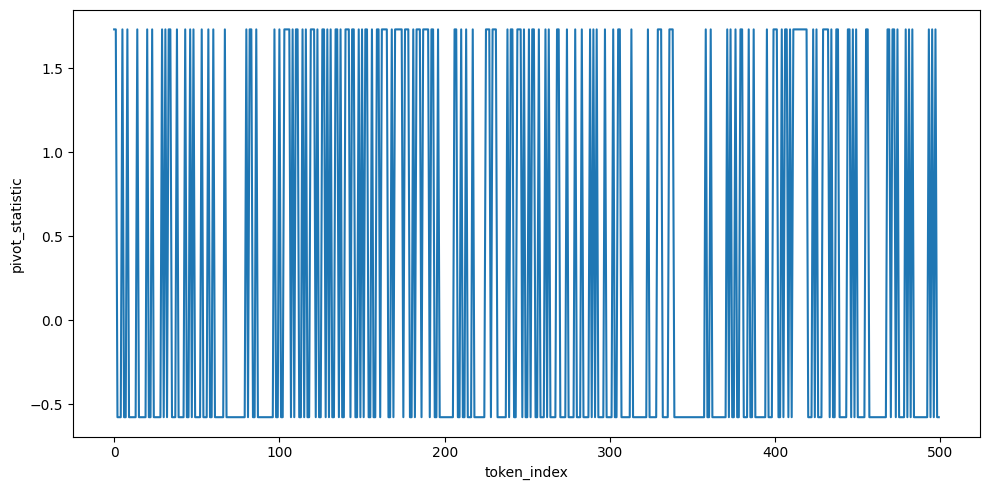

In [93]:
# sample plot for sanity testing
df = []
for sample_index, sample_data in enumerate(data["data"]):
    pivots = sample_data["pivots"]
    for token_index, pivot in enumerate(pivots):
        df.append({ "sample_index": sample_index, "token_index": token_index, "pivot_statistic": pivot})

df = pd.DataFrame(df)
agg_df = df.groupby(by = ['token_index'])[['pivot_statistic']].mean().reset_index() # plot the pivot statistic

plt.figure(figsize=(10, 5))
sns.lineplot(data=df.loc[df['sample_index'] == 1], # put agg_df in case of agg plot
             # agg_df,
             x='token_index', y='pivot_statistic')
plt.tight_layout()
plt.show()

In [96]:
def get_epidemic_intervals(x):
    d = EpidemicDetector(vocab_size=vocab_size)
    return d.detect(x, null_distn=null_distn, block_size=40, c = 2) 

# gumbel: block_size = 75, c = 2
# inverse: block_size = 40, c = 2
# red-green: block_size = 50, c = 1
# pf: block_size = 30, c = 2

get_summarized_results(data, get_epidemic_intervals)

  0%|          | 0/200 [00:00<?, ?it/s]

Model name: facebook/opt-125m
Output tokens: 500
Vocab size: 50272
Segment types: unwatermarked, redgreen, unwatermarked, redgreen, unwatermarked

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      1        172       0.860
1      0         17       0.085
2      2         11       0.055

Additional Metrics: 
Mean IOU: 0.23008726246358258
Mean Time Taken: 0.006125967502593994


{'model_name': 'facebook/opt-125m',
 'iou': np.float64(0.23008726246358258),
 'time': np.float64(6.125967502593994)}

In [86]:
alpha = 0.25
null_samples = null_distn((1000, ), vocab_size)
threshold = np.quantile(null_samples, 1 - alpha)

def get_aligator_intervals(x):
    # calculate threshold based on 95\% quantile of null distribution
    d = AligatorDetector(threshold=threshold)
    return d.detect(np.array(x))

get_summarized_results(data, get_aligator_intervals)

  0%|          | 0/200 [00:00<?, ?it/s]

Model name: facebook/opt-125m
Output tokens: 500
Vocab size: 50272
Segment types: unwatermarked, pf, unwatermarked, pf, unwatermarked

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      1         19       0.095
1      3         19       0.095
2      6         18       0.090
3      7         17       0.085
4      5         14       0.070

Additional Metrics: 
Mean IOU: 0.31825078841603016
Mean Time Taken: 0.22283722043037416


In [109]:
# run for all watermarking together, and then show the relevant results for latex

file_model_name = "data_facebook-opt-1-3b_n500"
watermarks = ["gumbel", "inverse", "redgreen", "pf"]
null_dist_list = {
    "gumbel": null_distn_gumbel,
    "inverse": null_distn_inverse,
    "redgreen": null_distn_redgreen,
    "pf": null_distn_pf
}

outputs = []
for method in watermarks:
    fname = f"{file_model_name}_{method}.json"
    data = read_json(os.path.join(root_output_path, fname))
    vocab_size = data['configuration']['vocab_size']

    null_distn = null_dist_list[method]

    alpha = 0.05
    null_samples = null_distn((1000, ), vocab_size)
    threshold = np.quantile(null_samples, 1 - alpha)

    def get_aligator_intervals(x):
        # calculate threshold based on 95\% quantile of null distribution
        d = AligatorDetector(threshold=threshold)
        return d.detect(np.array(x))
    res1 = get_summarized_results(data, get_aligator_intervals, verbose=False)

    def get_epidemic_intervals(x):
        d = EpidemicDetector(vocab_size=vocab_size)
        return d.detect(x, null_distn=null_distn, block_size=35, c = 2)
    res2 = get_summarized_results(data, get_epidemic_intervals, verbose=False)

    row = {
        "watermark": method,
        "aligator_time": float(res1['time']),
        "aligator_iou": float(res1['iou']),
        "epidemic_time": float(res2['time']),
        "epidemic_iou": float(res2['iou']) 
    }
    outputs.append(row)


pd.DataFrame(outputs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,watermark,aligator_time,aligator_iou,epidemic_time,epidemic_iou
0,gumbel,223.744947,0.360823,5.857030,0.547279
1,inverse,228.355308,0.000000,3.357002,0.424247
2,redgreen,230.004462,0.000000,6.526239,0.243115
3,pf,231.221128,0.240313,5.698959,0.529349


In [110]:
df1 =pd.DataFrame(outputs).round(3)
df1['latex'] = df1.apply(lambda x: f"{x['aligator_time']} & {x['aligator_iou']} & {x['epidemic_time']} & {x['epidemic_iou']}", axis = 1)
df1[['watermark', 'latex']]

,watermark,latex
0,gumbel,223.745 & 0.361 & 5.857 & 0.547
1,inverse,228.355 & 0.0 & 3.357 & 0.424
2,redgreen,230.004 & 0.0 & 6.526 & 0.243
3,pf,231.221 & 0.24 & 5.699 & 0.529
